In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

2023-05-02 19:03:38.273516: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 19:03:38.308059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 19:03:38.309095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 19:03:39.062345: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [102]:
baselines_eval_folder = 'outputs/baseline/procgen/52-55-04-01-05-2023-complete'
learned_eval_folders = [
    'outputs/eval/procgen/41-09-18-02-05-2023'
]

In [19]:
pd.read_csv(os.path.join(baselines_eval_folder, 'episode_stats.csv'))

,Meta-level Policy,Pretrained Percentile,Number of Steps,Return
0,Instant Terminate,0.25,10,0.0
1,Instant Terminate,0.25,24,2.0
2,Instant Terminate,0.25,33,5.0
3,Instant Terminate,0.25,36,2.0
4,Instant Terminate,0.25,13,0.0
...,...,...,...,...
1595,Random (No Terminate),0.90,500,111.0
1596,Random (No Terminate),0.90,329,80.0
1597,Random (No Terminate),0.90,500,106.0
1598,Random (No Terminate),0.90,176,41.0


In [110]:
episode_stats_df = pd.concat([
    pd.read_csv(os.path.join(baselines_eval_folder, 'episode_stats.csv')),
    *[pd.read_csv(os.path.join(folder, 'episode_stats.csv')) for folder in learned_eval_folders]
]).reset_index()

results_df = pd.concat([
    pd.read_csv(os.path.join(baselines_eval_folder, 'results.csv')),
    pd.read_csv(os.path.join(learned_eval_folders[0], 'results2.csv')),
    *[pd.read_csv(os.path.join(folder, 'results.csv')) for folder in learned_eval_folders]
]).reset_index()

In [107]:
episode_stats_df.head()

,index,Meta-level Policy,Pretrained Percentile,Number of Steps,Return
0,0,Instant Terminate,0.25,10,0.0
1,1,Instant Terminate,0.25,24,2.0
2,2,Instant Terminate,0.25,33,5.0
3,3,Instant Terminate,0.25,36,2.0
4,4,Instant Terminate,0.25,13,0.0


In [99]:
np.median

<function numpy.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)>

In [100]:
mean_stats_df = episode_stats_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()

In [88]:
sns.set(font_scale=2.5)

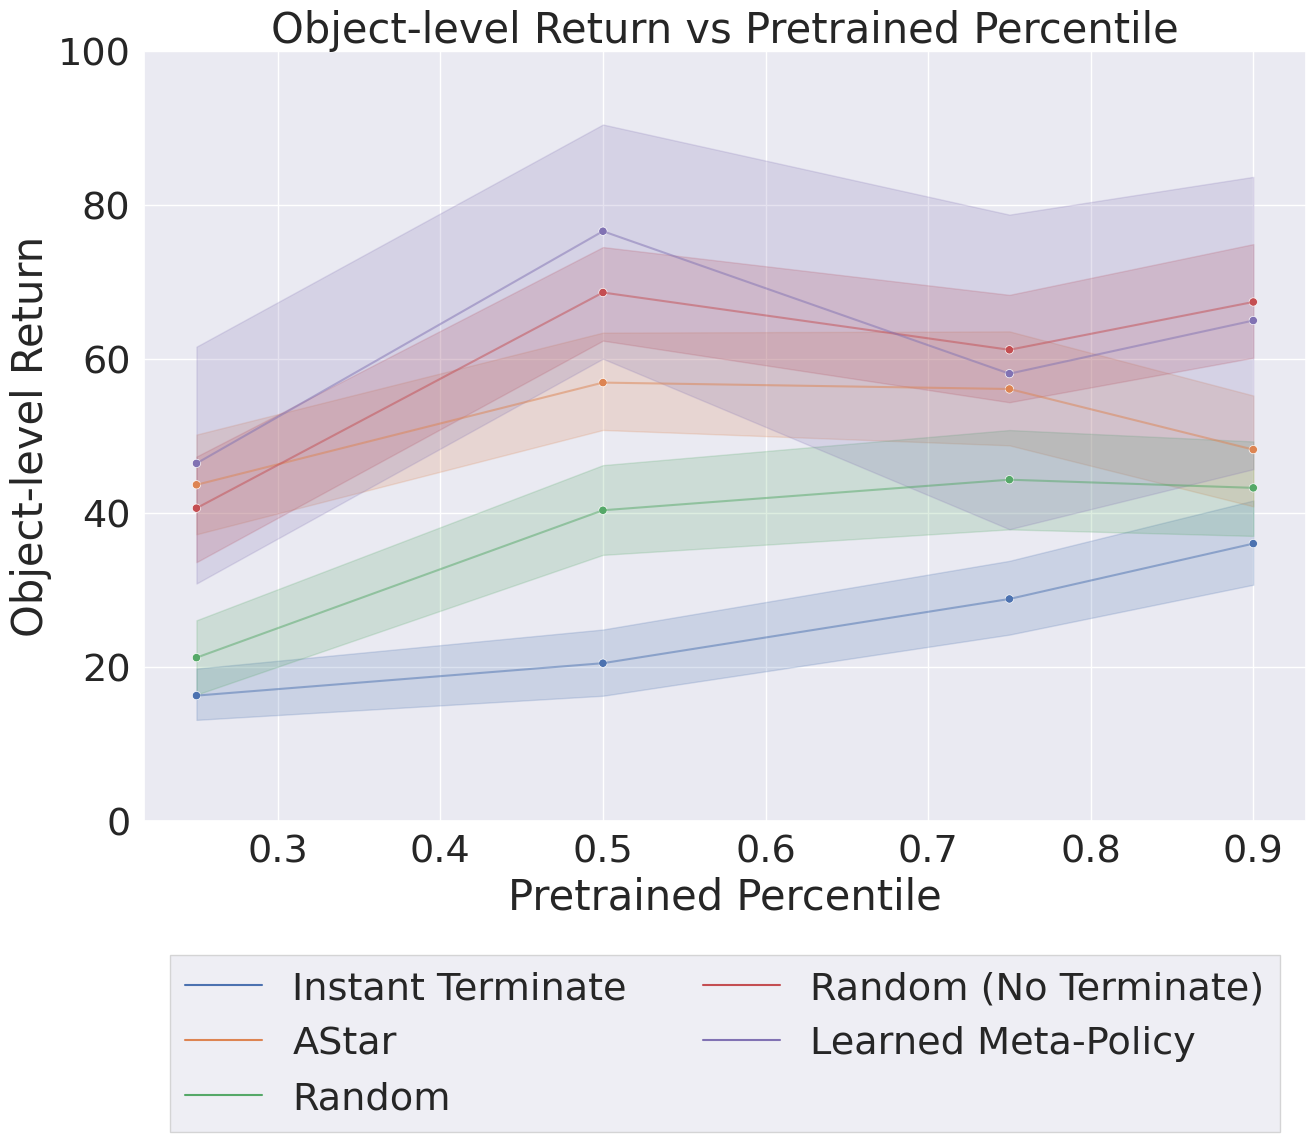

In [111]:
plt.figure(figsize=(15, 10))

ax = sns.lineplot(data=episode_stats_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', alpha=0.5)
sns.scatterplot(data=results_df, x='pretrained_percentile', y='ObjectLevelMeanReward', hue='Meta-level Policy', legend=False)
# sns.scatterplot(data=mean_stats_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy', legend=False)

# plt.xlabel('Pretrained Percentile')

plt.ylabel('Object-level Return')
plt.title(f'Object-level Return vs Pretrained Percentile')

plt.ylim([0, 100])
ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

# plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# plt.setp(ax.get_legend().get_title(), fontsize='20') 
# plt.savefig(self.output_dir / 'object-return-vs-percentile.png')

plt.show()